<a href="https://colab.research.google.com/github/sujitpal/nlp-deeplearning-ai-examples/blob/master/03_03_tx_bionlp_ner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Named Entity Recognition for BioNLP using BERT

We will train a Named Entity Recognition (NER) model using a BERT transformer with a head for token classification, using the [JNLPBA dataset](http://www.nactem.ac.uk/GENIA/current/Shared-tasks/JNLPBA/).

__References__

* [Lessons Learned from fine-tuning BERT for Named Entity Recognition](https://gab41.lab41.org/lessons-learned-fine-tuning-bert-for-named-entity-recognition-4022a53c0d90) by Charlene Chambliss, Jan 30 2020.

In [1]:
!pip install transformers

     |████████████████████████████████| 1.5MB 13.6MB/s 
     |████████████████████████████████| 890kB 51.3MB/s 
     |████████████████████████████████| 2.9MB 51.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=651b61a912b8577b7eb853bcf26ea2bd8701441708a8a9c98bf16cdf103a5b76
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


### Setup

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import torch

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from transformers import BertForTokenClassification, BertTokenizer
from torch.utils.data import Dataset, DataLoader

%matplotlib inline

In [4]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)           # we mount the google drive at /content/drive

/content/drive
Mounted at /content/drive


In [5]:
DATA_DIR = os.path.join(ROOT, "MyDrive", "nlp-deeplearning-ai-data")
TRAIN_FILE = os.path.join(DATA_DIR, "jnlpba-train.iob")
TEST_FILE = os.path.join(DATA_DIR, "jnlpba-test.iob")

### Read IOB file

Data is provided in two files, train and test, both in IOB format. We read these files and transform them into list of lists of tokens and tags, then split them into training, validation, and test sets.

Because we are using BERT transformers as our encoder, we will also use the BERT tokenizer, which does wordpiece tokenization, so we will reconstruct each list of tokens and tags into a string, i.e., a sentence and a space separated sequence of IOB tags.

In [6]:
def process_iob_file(iob_filepath):
  nlines = 0
  inputs, labels = [], []
  with open(iob_filepath, "r") as f:
    tokens, tags = [], []
    for line in f:
      if nlines % 100000 == 0:
        print("{:s}: {:d} lines processed".format(iob_filepath.split("/")[-1], nlines))
      line = line.strip()
      if len(line) == 0:
        inputs.append(" ".join(tokens))
        labels.append(" ".join(tags))
        tokens, tags = [], []
        continue
      token, tag = line.split('\t')
      tokens.append(token)
      tags.append(tag)
      nlines += 1

    inputs.append(" ".join(tokens))
    labels.append(" ".join(tags))
    print("{:s}: {:d} lines processed, COMPLETE\n".format(iob_filepath.split("/")[-1], nlines))
    return inputs, labels

# parse file of training IOB tags and split into training and validation
tv_inputs, tv_labels = process_iob_file(TRAIN_FILE)
train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    tv_inputs, tv_labels, test_size=0.1, random_state=0)
# parse file of held-out test IOB tags
test_inputs, test_labels = process_iob_file(TEST_FILE)

len(train_inputs), len(train_labels), len(val_inputs), len(val_labels), len(test_inputs), len(test_labels)

jnlpba-train.iob: 0 lines processed
jnlpba-train.iob: 100000 lines processed
jnlpba-train.iob: 200000 lines processed
jnlpba-train.iob: 300000 lines processed
jnlpba-train.iob: 400000 lines processed
jnlpba-train.iob: 492551 lines processed, COMPLETE

jnlpba-test.iob: 0 lines processed
jnlpba-test.iob: 100000 lines processed
jnlpba-test.iob: 101039 lines processed, COMPLETE



(16692, 16692, 1855, 1855, 3857, 3857)

Colab complained about being out of memory, which prompted this analysis. Essentially, there are some very long sentences. Since we are using Pytorch, which allows batch oriented padding, some of our input sequences get very long, so we drop sentences whose length (in number of tokens) are greater than 40. This allows us to keep 90% of our dataset.

Rather than doing it up-front, we just drop the long sentences from each data split.

percentile with sentence length cutoffs: ['(80%, 35)', '(90%, 41)', '(95%, 47)', '(99%, 63)', '(100%, 204)']


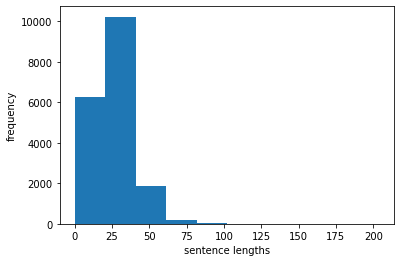

In [7]:
sentence_lengths = [len(input.split()) for input in tv_inputs]

pct_points = [80, 90, 95, 99, 100]
pcts = np.percentile(sentence_lengths, pct_points)
print("percentile with sentence length cutoffs:", 
      ["({:d}%, {:.0f})".format(pp, pct) for pp, pct in zip(pct_points, pcts)])

plt.hist(sentence_lengths)
plt.xlabel("sentence lengths")
plt.ylabel("frequency")
_ = plt.show()

In [8]:
def discard_long_sentences(inputs, labels, max_tokens=40):
  xys = [(x, y) for x, y in zip(inputs, labels) if len(x.split()) < max_tokens]
  xs, ys = [], []
  for x, y in xys:
    xs.append(x)
    ys.append(y)
  return xs, ys


train_inputs, train_labels = discard_long_sentences(train_inputs, train_labels, 40)
val_inputs, val_labels = discard_long_sentences(val_inputs, val_labels, 40)
test_inputs, test_labels = discard_long_sentences(test_inputs, test_labels, 40)

len(train_inputs), len(train_labels), len(val_inputs), len(val_labels), len(test_inputs), len(test_labels)

(14618, 14618, 1619, 1619, 3370, 3370)

We will use the BERT vocabulary to tokenize English sentences on our input side.

The output side is a sequence of IOB tags. So we will build a "vocabulary" of IOB tags that we pull from our provided training set (the `train.iob` file).

In addition, we add in a `PAD` tag and an `X` tag. The `X` tag is to handle word-pieces. For example, consider the word `isolates`, the Word Piece tokenizer will tokenize it into `[isol, ##ate, ##s]`. The corresponding IOB tag for the word is `O`. So after word-piece tokenization, we will assign the tags `[O, X, X]` for the word `isolates`.

In [9]:
labels_list = [x.split() for x in tv_labels]
unique_labels = set(itertools.chain.from_iterable(labels_list))

idx2label = {i+2:x for i, x in enumerate(sorted(list(unique_labels)))}
idx2label[0] = "PAD"
idx2label[1] = "X"

label2idx = {v:k for k, v in idx2label.items()}

idx2label

{0: 'PAD',
 1: 'X',
 2: 'B-DNA',
 3: 'B-RNA',
 4: 'B-cell_line',
 5: 'B-cell_type',
 6: 'B-protein',
 7: 'I-DNA',
 8: 'I-RNA',
 9: 'I-cell_line',
 10: 'I-cell_type',
 11: 'I-protein',
 12: 'O'}

### Declare Model and Tokenizer

We instantiate a BertForTokenClassification model based on a pre-trained `bert-base-cased` model. Cased models are usually better to use for Named Entity Recognition.

This is just a BERT encoder that reads a sequence of word piece tokens representing a sentence and outputs a vector into a sequence-based decoder head (like an LSTM).

Note that we have to provide the number of labels the decoder will emit (default if not set is 2, which is unsuitable for our purpose).

In [10]:
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
model = BertForTokenClassification.from_pretrained("bert-base-cased", num_labels=len(label2idx))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [11]:
dev = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(dev)

### Dataset

Our custom dataset emits a tuple of (sentence: String, label_sequence: String). We do the padding with the `X` tag for word-pieces described above in this block of code, the Dataset will output the label sequence suitably padded with X as needed.

We do the word piece tokenization twice, here, and again during consuming the batch, which is a bit of an inefficiency.

In [12]:
class NERDataset(Dataset):
  def __init__(self, inputs, labels, tokenizer):
    super().__init__()
    self.inputs = inputs
    self.labels = labels
    self.tokenizer = tokenizer

  def __len__(self):
    return len(self.inputs)

  def __getitem__(self, idx):
    input_i = self.inputs[idx].split()
    label_i = self.labels[idx].split()
    input_o, label_o = [], []
    for token_i, label_i in zip(input_i, label_i):
      token_wp = self.tokenizer.tokenize(token_i)
      label_wp = [label_i] + ["X"] * (len(token_wp) - 1)
      label_o.extend(label_wp)
    return self.inputs[idx], " ".join(label_o)


train_ds = NERDataset(train_inputs, train_labels, tokenizer)
val_ds = NERDataset(val_inputs, val_labels, tokenizer)
test_ds = NERDataset(test_inputs, test_labels, tokenizer)

# for testing
# train_ds = NERDataset(train_inputs[0:100], train_labels[0:100], tokenizer)
# val_ds = NERDataset(val_inputs[0:10], val_labels[0:10], tokenizer)
# test_ds = NERDataset(test_inputs[0:20], test_labels[0:20], tokenizer)

# self-test
test_tokens_12, test_labels_12 = train_ds[12]
print("test_tokens[12]:", test_tokens_12)
print("test_labels[12]:", test_labels_12)

test_tokens[12]: Thus enabled to perform the test on multiple blood samples in parallel , we investigated cardiac infarction patients over a 12-day period to test if glucocorticoid receptor binding is altered in this 'stressful ' disease .
test_labels[12]: O O O O O O O O B-cell_type I-cell_type O O O O O O O X X O O O O X X O O O O B-protein X X X X X I-protein O O O O O O X X O O O


In [13]:
BATCH_SIZE = 32

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

### Training

In [14]:
NUM_EPOCHS = 5
LEARNING_RATE = 3e-5

In [15]:
def convert_labels_to_tensor(tags, batch_size, padding_length, label2idx):
  padded_labels = []
  for tag in tags:
    tag_list = tag.split()
    curr_length = len(tag_list)
    tag_list.extend(["PAD"] * (padding_length - curr_length))
    padded_labels.append(np.array([label2idx[tag] for tag in tag_list]))
  return torch.as_tensor(np.array(padded_labels, dtype=np.int64))


# self-test
test_label = "O X X X O O O B-protein X X X X X O O O O O O O O O X X X O"
test_tensor = convert_labels_to_tensor([test_label], 1, len(test_label.split()) + 2, label2idx)
assert(test_tensor.size(1) == len(test_label.split()) + 2)
test_tensor, test_tensor.dtype

(tensor([[12,  1,  1,  1, 12, 12, 12,  6,  1,  1,  1,  1,  1, 12, 12, 12, 12, 12,
          12, 12, 12, 12,  1,  1,  1, 12,  0,  0]]), torch.int64)

In [16]:
class Accuracy():
  def __init__(self, tokenizer, idx2label):
    super().__init__()
    self.tokenizer = tokenizer
    self.idx2label = idx2label
    self.preds_list = []
    self.labels_list = []

  def accumulate(self, input_ids, logits, labels):
    preds_mask = (
        (input_ids != self.tokenizer.cls_token_id) &
        (input_ids != self.tokenizer.pad_token_id) &
        (input_ids != self.tokenizer.sep_token_id))
    _, predictions = torch.max(logits, 2)

    pred_ids = torch.masked_select(predictions, (preds_mask == 1))
    label_ids = torch.masked_select(labels, (preds_mask == 1))

    self.preds_list.extend(pred_ids.detach().cpu().numpy().tolist())
    self.labels_list.extend(label_ids.detach().cpu().numpy().tolist())

  def compute(self):
    num_correct = sum([lab == pred for lab, pred 
                     in zip(self.labels_list, self.preds_list)
                     if self.idx2label[lab] != "X"]) 
    num_total = len([lab for lab in self.labels_list 
                     if self.idx2label[lab] != "X"])
    if num_total > 0:
      return num_correct / num_total
    else:
      return 0.0


In [17]:
def train(train_dl, model, tokenizer, optimizer, label2idx, idx2label):
  total_loss = 0
  train_acc = Accuracy(tokenizer, idx2label)
  model.train()
  for batch in train_dl:
    tokens, tags = batch

    inputs = tokenizer(tokens, truncation=True, padding=True, return_tensors="pt")
    input_ids = inputs.input_ids
    attention_mask = inputs.attention_mask
    curr_batch_size, curr_pad_length = input_ids.size()
    labels = convert_labels_to_tensor(
        tags, curr_batch_size, curr_pad_length, label2idx)

    input_ids, attention_mask = input_ids.to(dev), attention_mask.to(dev)
    labels = labels.to(dev)

    outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

    loss, logits = outputs.loss, outputs.logits

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    total_loss += loss.item()
    train_acc.accumulate(input_ids, logits, labels)

  return total_loss, train_acc.compute()


def evaluate(val_dl, model, tokenizer, label2idx, idx2label):
  val_loss = 0
  val_acc = Accuracy(tokenizer, idx2label)
  model.eval()
  for batch in val_dl:
    tokens, tags = batch

    inputs = tokenizer(tokens, truncation=True, padding=True, return_tensors="pt")
    input_ids = inputs.input_ids
    attention_mask = inputs.attention_mask
    curr_batch_size, curr_pad_length = input_ids.size()
    labels = convert_labels_to_tensor(tags, curr_batch_size, curr_pad_length, label2idx)

    input_ids, attention_mask = input_ids.to(dev), attention_mask.to(dev)
    labels = labels.to(dev)

    with torch.no_grad():
      outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
      loss, logits = outputs.loss, outputs.logits

    val_loss += loss.item()
    val_acc.accumulate(input_ids, logits, labels)

  return val_loss, val_acc.compute()

In [18]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

In [19]:
losses, accs, val_losses, val_accs = [], [], [], []
for epoch in range(1, NUM_EPOCHS + 1):
  train_loss, train_acc = train(train_dl, model, 
                                tokenizer, optimizer, 
                                label2idx, idx2label)
  val_loss, val_acc = evaluate(val_dl, model, tokenizer, 
                               label2idx, idx2label)
  print("Epoch {:d} | train loss: {:.3f}, accuracy: {:.3f} | validation loss: {:.3f}, accuracy: {:.3f}"
    .format(epoch, train_loss, train_acc, val_loss, val_acc))
  losses.append(train_loss)
  accs.append(train_acc)
  val_losses.append(val_loss)
  val_accs.append(val_acc)

Epoch 1 | train loss: 100.282, accuracy: 0.902 | validation loss: 5.818, accuracy: 0.941
Epoch 2 | train loss: 47.488, accuracy: 0.946 | validation loss: 5.908, accuracy: 0.940
Epoch 3 | train loss: 38.640, accuracy: 0.956 | validation loss: 5.299, accuracy: 0.946
Epoch 4 | train loss: 32.249, accuracy: 0.963 | validation loss: 5.398, accuracy: 0.948
Epoch 5 | train loss: 26.926, accuracy: 0.969 | validation loss: 5.459, accuracy: 0.949


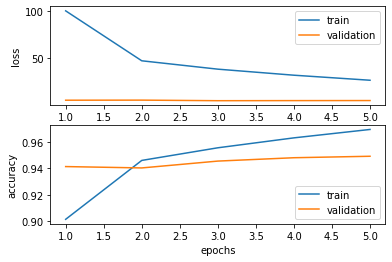

In [20]:
plt.subplot(2, 1, 1)
xs = np.arange(NUM_EPOCHS) + 1
plt.plot(xs, losses, label="train")
plt.plot(xs, val_losses, label="validation")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc="best")

plt.subplot(2, 1, 2)
plt.plot(xs, accs, label="train")
plt.plot(xs, val_accs, label="validation")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(loc="best")

_ = plt.show()

### Prediction

In [21]:
def predict(test_batch, model, tokenizer, label2idx, idx2label):
  model.eval()
  tokens, tags = test_batch

  inputs = tokenizer(tokens, truncation=True, padding=True, return_tensors="pt")
  input_ids = inputs.input_ids
  attention_mask = inputs.attention_mask
  curr_batch_size, curr_pad_length = input_ids.size()
  labels = convert_labels_to_tensor(tags, curr_batch_size, curr_pad_length, label2idx)

  input_ids, attention_mask = input_ids.to(dev), attention_mask.to(dev)
  labels = labels.to(dev)

  with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
    loss, logits = outputs.loss, outputs.logits

  preds_mask = (
      (input_ids != tokenizer.cls_token_id) &
      (input_ids != tokenizer.pad_token_id) &
      (input_ids != tokenizer.sep_token_id))
  _, predictions = torch.max(logits, 2)

  batch_predictions = []
  for i in range(predictions.size(0)):
    masked_prediction = torch.masked_select(predictions[i], (preds_mask[i] == 1))
    masked_prediction = masked_prediction.detach().cpu().numpy()
    predicted_tags = [idx2label[p] for p in masked_prediction if idx2label[p] != "X"]
    batch_predictions.append(" ".join(predicted_tags))

  return batch_predictions


def postprocess_tags(tags):
  tags_pp = []
  for t in tags:
    if t == "PAD":
      tags_pp.append("O")
    elif t.startswith("I-") or t.startswith("B-"):
      tags_pp.append(t[2:])
    else:
      tags_pp.append(t)
  return tags_pp

In [22]:
num_examples = 0
pred_list, label_list = [], []
for test_batch in test_dl:
  inputs, labels = test_batch
  preds = predict(test_batch, model, tokenizer, label2idx, idx2label)
  for input, label, pred in zip(inputs, labels, preds):
    label_wox_toks = [x for x in label.split() if x != "X"]
    pred_toks = pred.split()
    # make them the same length (forcibly)
    if len(pred_toks) > len(label_wox_toks):
      pred_toks = pred_toks[0 : len(label_wox_toks)]
    elif len(pred_toks) < len(label_wox_toks):
      diff_num_toks = len(label_wox_toks) - len(pred_toks)
      pred_toks.extend(["O"] * diff_num_toks)
    # display first 10 results
    if num_examples < 10:
      print("input ({:d} tokens):".format(len(input.split())), input)
      print("label ({:d} tokens):".format(len(label_wox_toks)), " ".join(label_wox_toks))
      print("preds ({:d} tokens):".format(len(pred_toks)), " ".join(pred_toks))
      print("--")
    # replace PAD with O, and remove I- and B- prefixes from both label and preds
    pred_list.extend(postprocess_tags(pred_toks))
    label_list.extend(postprocess_tags(label_wox_toks))
    num_examples += 1


input (13 tokens): Number of glucocorticoid receptors in lymphocytes and their sensitivity to hormone action .
label (13 tokens): O O B-protein I-protein O B-cell_type O O O O O O O
preds (13 tokens): O B-protein I-protein O B-cell_type O O O O O O O PAD
--
input (31 tokens): The study demonstrated a decreased level of glucocorticoid receptors ( GR ) in peripheral blood lymphocytes from hypercholesterolemic subjects , and an elevated level in patients with acute myocardial infarction .
label (31 tokens): O O O O O O O B-protein I-protein O B-protein O O B-cell_type I-cell_type I-cell_type O O O O O O O O O O O O O O O
preds (31 tokens): O O O O O O B-protein I-protein O B-protein O O B-cell_type I-cell_type I-cell_type O O O O O O O O O O O O O O O PAD
--
input (38 tokens): In the lymphocytes with a high GR number , dexamethasone inhibited [ 3H ] -thymidine and [ 3H ] -acetate incorporation into DNA and cholesterol , respectively , in the same manner as in the control cells .
label (38

In [23]:
labels = [lab for lab in label2idx.keys() 
          if lab.startswith("B-") or lab.startswith("I-") or lab == "O"]
labels = sorted(list(set(map(lambda x: x[2:] 
                             if x.startswith("I-") or x.startswith("B-") else x, labels))))
labels

['DNA', 'O', 'RNA', 'cell_line', 'cell_type', 'protein']

In [24]:
print(confusion_matrix(label_list, pred_list, labels=labels))

[[ 1182   821     2     2     0    49]
 [  987 54872   119   470  1393  4476]
 [    3    91   125     0     1     2]
 [    0   411     0   527    95     7]
 [    2  1725     0   195  1870    46]
 [   74  4159    22    32    20  3288]]


In [25]:
print(classification_report(label_list, pred_list, labels=labels))

              precision    recall  f1-score   support

         DNA       0.53      0.57      0.55      2056
           O       0.88      0.88      0.88     62317
         RNA       0.47      0.56      0.51       222
   cell_line       0.43      0.51      0.47      1040
   cell_type       0.55      0.49      0.52      3838
     protein       0.42      0.43      0.43      7595

    accuracy                           0.80     77068
   macro avg       0.55      0.57      0.56     77068
weighted avg       0.80      0.80      0.80     77068

